<a href="https://colab.research.google.com/github/kimbob123/SNU_FinTech/blob/main/%EB%AC%B4%EC%A7%80%EC%84%B1_LSTM_%EA%B9%83%ED%97%88%EB%B8%8C%EC%9C%A0%EB%8F%99%EA%B5%AD_%EC%B0%B8%EA%B3%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#시작

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install datasets

In [3]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
import transformers

In [4]:
import pkg_resources

# 확인할 패키지 리스트
packages_to_check = [
    "datasets",
    "ipykernel",
    "ipython",
    "numpy",
    "pandas",
    "pytz",
    "torch",
    "torchaudio",
    "torchtext",
    "torchvision",
    "tqdm"
]

# 설치된 패키지의 이름과 버전 출력
installed_packages = pkg_resources.working_set
for package in installed_packages:
    if package.project_name in packages_to_check:
        print(f"{package.project_name}=={package.version}")


datasets==2.19.1
ipykernel==5.5.6
ipython==7.34.0
numpy==1.25.2
pandas==2.0.3
pytz==2023.4
torch==2.3.0+cu121
torchaudio==2.3.0+cu121
torchtext==0.18.0
torchvision==0.18.0+cu121
tqdm==4.66.4


In [5]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

#전처리

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [7]:
test_data = pd.read_csv('/content/drive/MyDrive/챗봇 답변 선호/test.csv')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          3 non-null      int64 
 1   prompt      3 non-null      object
 2   response_a  3 non-null      object
 3   response_b  3 non-null      object
dtypes: int64(1), object(3)
memory usage: 224.0+ bytes


In [8]:
test_data

,id,prompt,response_a,response_b
0,136060,"[""I have three oranges today, I ate an orange ...","[""You have two oranges today.""]","[""You still have three oranges. Eating an oran..."
1,211333,"[""You are a mediator in a heated political deb...","[""Thank you for sharing the details of the sit...","[""Mr Reddy and Ms Blue both have valid points ..."
2,1233961,"[""How to initialize the classification head wh...","[""When you want to initialize the classificati...","[""To initialize the classification head when p..."


In [9]:
train_data = pd.read_csv('/content/drive/MyDrive/챗봇 답변 선호/train.csv')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57477 entries, 0 to 57476
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              57477 non-null  int64 
 1   model_a         57477 non-null  object
 2   model_b         57477 non-null  object
 3   prompt          57477 non-null  object
 4   response_a      57477 non-null  object
 5   response_b      57477 non-null  object
 6   winner_model_a  57477 non-null  int64 
 7   winner_model_b  57477 non-null  int64 
 8   winner_tie      57477 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 3.9+ MB


In [10]:
train_data

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0
...,...,...,...,...,...,...,...,...,...
57472,4294656694,gpt-4-0613,claude-1,"[""A simple mnemonic for \u03c0:\n\""How I wish ...","[""Sure, let's break it down:\n\n1. \""How\"" has...","[""Here is how that mnemonic represents the dig...",1,0,0
57473,4294692063,claude-2.0,llama-2-13b-chat,"[""In python, implement a naive Bayes with gaus...","[""Here is an implementation of a naive Bayes c...","[""Sure! Here's an implementation of a naive Ba...",1,0,0
57474,4294710549,claude-1,alpaca-13b,"[""is it unethical to work on building weapons?...","[""Working on weapons technology raises some et...","[""It depends on the context. Weapons can be us...",1,0,0
57475,4294899228,palm-2,tulu-2-dpo-70b,"[""If a bait contains 0,0025% bromadiolon then ...","[""Bromadiolone is a rodenticide which is most ...","[""As an AI language model, I do not promote or...",0,1,0


In [11]:
def assign_label(row):
    if row['winner_tie'] == 1:
        return 1, 1, row['response_a'], row['response_b']
    elif row['winner_model_a'] == 1:
        return 2, 0, row['response_a'], row['response_b']
    elif row['winner_model_b'] == 1:
        return 0, 2, row['response_a'], row['response_b']

# 'assign_label' 함수를 적용하여 'label'과 'response' 열 생성
train_data['label_a'], train_data['label_b'], train_data['response_a'], train_data['response_b'] = zip(*train_data.apply(assign_label, axis=1))

# 필요한 열만 선택 후 id와 response_a, response_b를 다루어 새로운 데이터프레임 생성
response_a_df = train_data[['id', 'response_a', 'label_a']].rename(columns={'response_a': 'response', 'label_a': 'label'})
response_b_df = train_data[['id', 'response_b', 'label_b']].rename(columns={'response_b': 'response', 'label_b': 'label'})
train_data = pd.concat([response_a_df, response_b_df], ignore_index=True)
train_data


,id,response,label
0,30192,"[""The question of whether it is morally right ...",2
1,53567,"[""A marriage license is a legal document that ...",0
2,65089,"[""Function calling is the process of invoking ...",1
3,96401,"[""Creating a test set for a very rare category...",2
4,198779,"[""The best way to travel from Tel Aviv to Jeru...",0
...,...,...,...
114949,4294656694,"[""Here is how that mnemonic represents the dig...",0
114950,4294692063,"[""Sure! Here's an implementation of a naive Ba...",0
114951,4294710549,"[""It depends on the context. Weapons can be us...",0
114952,4294899228,"[""As an AI language model, I do not promote or...",2


## 토큰화

In [12]:
train_data

,id,response,label
0,30192,"[""The question of whether it is morally right ...",2
1,53567,"[""A marriage license is a legal document that ...",0
2,65089,"[""Function calling is the process of invoking ...",1
3,96401,"[""Creating a test set for a very rare category...",2
4,198779,"[""The best way to travel from Tel Aviv to Jeru...",0
...,...,...,...
114949,4294656694,"[""Here is how that mnemonic represents the dig...",0
114950,4294692063,"[""Sure! Here's an implementation of a naive Ba...",0
114951,4294710549,"[""It depends on the context. Weapons can be us...",0
114952,4294899228,"[""As an AI language model, I do not promote or...",2


In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114954 entries, 0 to 114953
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        114954 non-null  int64 
 1   response  114954 non-null  object
 2   label     114954 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.6+ MB


In [14]:
train_data = datasets.Dataset.from_pandas(train_data)

In [15]:
from torchtext.data.utils import get_tokenizer
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

def tokenize_example(example, tokenizer, max_length):
    tokens = tokenizer(example["response"])[:max_length]
    length = len(tokens)
    return {"tokens": tokens, "length": length}



max_length = 100

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [16]:
train_data = train_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

Map:   0%|          | 0/114954 [00:00<?, ? examples/s]

In [17]:
train_data[10]

{'id': 497862,
 'response': '["Sure, here\'s a Python function that uses the `boto3` library to upload all files from a local folder to a directory in an S3 bucket:\\n```python\\nimport boto3\\nimport os\\n\\ndef upload_files_to_s3(bucket_name, local_folder, s3_folder):\\n    # Connect to S3\\n    s3 = boto3.resource(\'s3\')\\n    s3_bucket = s3.Bucket(bucket_name)\\n\\n    # Get the files in the local folder\\n    files = os.listdir(local_folder)\\n\\n    # Iterate through the files and upload them to the S3 folder\\n    for file in files:\\n        file_path = os.path.join(local_folder, file)\\n        s3.meta.client.upload_file(file_path, s3_bucket, s3_folder + \\"\\/\\" + file)\\n\\n    print(\\"All files uploaded to S3 bucket.\\")\\n```\\nTo use this function, you need to provide the name of the S3 bucket, the local folder containing the files you want to upload, and the name of the directory in the S3 bucket where you want to upload the files. Here\'s an example of how to use the

In [18]:
train_data[0]["tokens"][:25]


['[the',
 'question',
 'of',
 'whether',
 'it',
 'is',
 'morally',
 'right',
 'to',
 'aim',
 'for',
 'a',
 'certain',
 'percentage',
 'of',
 'females',
 'in',
 'managerial',
 'positions',
 'is',
 'a',
 'complex',
 'ethical',
 'issue',
 'that']

In [19]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

In [20]:
len(train_data), len(valid_data)

(86215, 28739)

## Vocab 만들기

In [21]:
min_freq = 5
special_tokens = ["<unk>", "<pad>"]
from torchtext.vocab import Vocab
vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [22]:
len(vocab)

42554

In [23]:
vocab.get_itos()[:10]


['<unk>', '<pad>', ',', '.', 'the', 'a', 'and', 'to', 'of', 'is']

In [24]:
vocab["and"]

6

In [25]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

## 숫자화

In [26]:
vocab.set_default_index(unk_index) #이거 없으면 numericalize 안돌아감 ;;

In [27]:
#여기서 글자를 숫자로 만드는구나...
def numericalize(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids": ids}

In [28]:
train_data = train_data.map(numericalize, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize, fn_kwargs={"vocab": vocab})

Map:   0%|          | 0/86215 [00:00<?, ? examples/s]

Map:   0%|          | 0/28739 [00:00<?, ? examples/s]

## 토치화

In [29]:
train_data = train_data.with_format(type="torch", columns=["ids", "label", 'length'])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label", 'length'])

In [30]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_length = [i["length"] for i in batch]
        batch_length = torch.stack(batch_length)
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "length": batch_length, "label": batch_label}
        return batch

    return collate_fn

In [31]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [32]:
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)

In [33]:
vectors = torchtext.vocab.GloVe()
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

# 모델! LSTM

In [34]:
class LSTM(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        n_layers,
        bidirectional,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            n_layers,
            bidirectional=bidirectional,
            dropout=dropout_rate,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids, length):
        # ids = [batch size, seq len]
        # length = [batch size]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, length, batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        # output = [batch size, seq len, hidden dim * n directions]
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
            # hidden = [batch size, hidden dim * 2]
        else:
            hidden = self.dropout(hidden[-1])
            # hidden = [batch size, hidden dim]
        prediction = self.fc(hidden)
        # prediction = [batch size, output dim]
        return prediction

In [35]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 128
output_dim = len(train_data.unique("label"))
n_layers = 4
bidirectional = True
dropout_rate = 0.2

lstm_model = LSTM(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_index,
)

In [36]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(lstm_model):,} trainable parameters")

The model has 14,393,083 trainable parameters


In [37]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)

In [38]:
lstm_model.apply(initialize_weights)

LSTM(
  (embedding): Embedding(42554, 300, padding_idx=1)
  (lstm): LSTM(300, 128, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [39]:
lstm_model.embedding.weight.data = pretrained_embedding

In [40]:
lr = 5e-4

optimizer = optim.Adam(lstm_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [41]:
# cuda 사용함
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [42]:
lstm_model = lstm_model.to(device)
criterion = criterion.to(device)

In [43]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [44]:
def train(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(dataloader, desc="training..."):
        ids = batch["ids"].to(device)
        length = batch["length"]
        label = batch["label"].to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [45]:
def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            length = batch["length"]
            label = batch["label"].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

#LSTM 학습 & Val 평가

In [46]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, lstm_model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, lstm_model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(lstm_model.state_dict(), "base_lstm.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|██████████| 57/57 [00:03<00:00, 14.36it/s]


epoch: 0
train_loss: 1.088, train_acc: 0.381
valid_loss: 1.081, valid_acc: 0.401


evaluating...: 100%|██████████| 57/57 [00:03<00:00, 14.31it/s]


epoch: 1
train_loss: 1.075, train_acc: 0.406
valid_loss: 1.075, valid_acc: 0.408


evaluating...: 100%|██████████| 57/57 [00:04<00:00, 14.14it/s]


epoch: 2
train_loss: 1.048, train_acc: 0.442
valid_loss: 1.080, valid_acc: 0.404


evaluating...: 100%|██████████| 57/57 [00:04<00:00, 13.85it/s]


epoch: 3
train_loss: 0.986, train_acc: 0.500
valid_loss: 1.098, valid_acc: 0.403


evaluating...: 100%|██████████| 57/57 [00:04<00:00, 13.18it/s]


epoch: 4
train_loss: 0.905, train_acc: 0.560
valid_loss: 1.145, valid_acc: 0.398


evaluating...: 100%|██████████| 57/57 [00:04<00:00, 13.70it/s]


epoch: 5
train_loss: 0.821, train_acc: 0.613
valid_loss: 1.194, valid_acc: 0.397


evaluating...: 100%|██████████| 57/57 [00:04<00:00, 13.81it/s]


epoch: 6
train_loss: 0.742, train_acc: 0.658
valid_loss: 1.267, valid_acc: 0.393


evaluating...: 100%|██████████| 57/57 [00:04<00:00, 13.84it/s]


epoch: 7
train_loss: 0.672, train_acc: 0.693
valid_loss: 1.410, valid_acc: 0.391


evaluating...: 100%|██████████| 57/57 [00:04<00:00, 13.16it/s]


epoch: 8
train_loss: 0.608, train_acc: 0.726
valid_loss: 1.542, valid_acc: 0.389


evaluating...: 100%|██████████| 57/57 [00:04<00:00, 13.63it/s]

epoch: 9
train_loss: 0.551, train_acc: 0.756
valid_loss: 1.667, valid_acc: 0.390


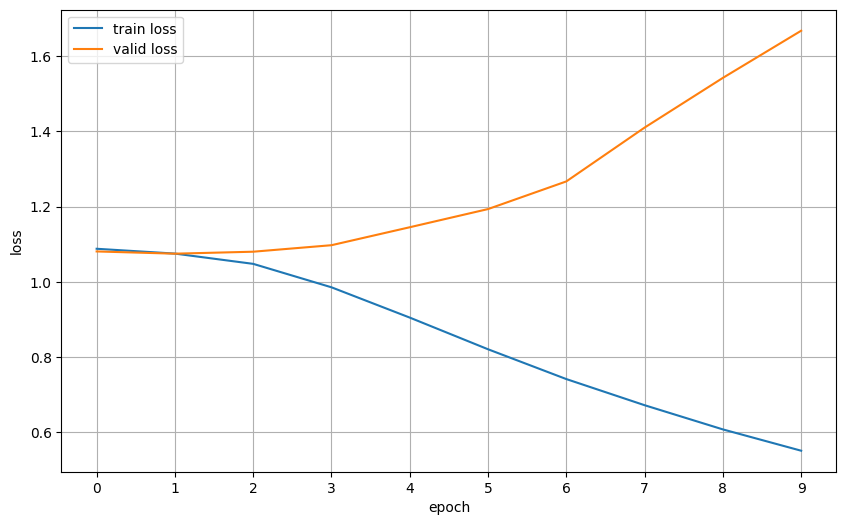

In [47]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

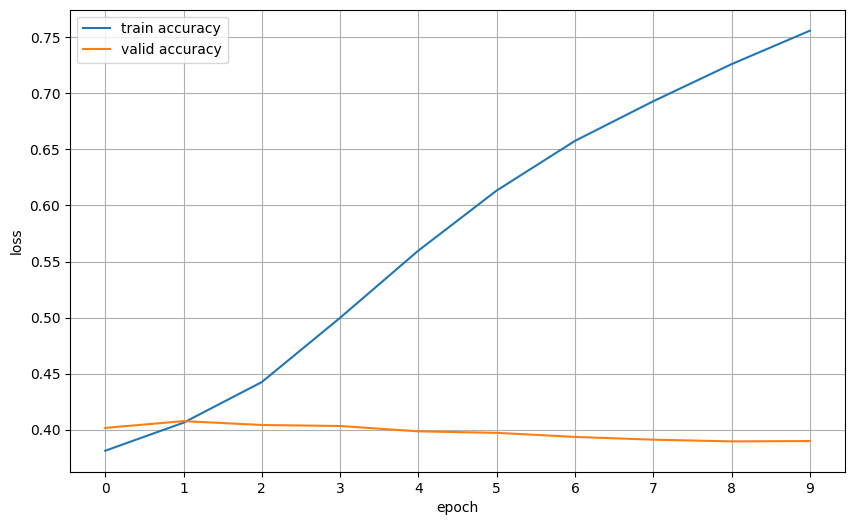

In [48]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()